In [1]:
import tensorly as tl
from tensorly import decomposition
import numpy as np

In [2]:
PLUS = np.array([.5 ** .5, .5 ** .5])
GHZ = np.array([.5 ** .5, 0, 0, 0, 0, 0, 0, .5 ** .5])
BELL = np.array([.5 ** .5, 0, 0, .5 ** .5])

noise16 = (np.random.random((16,)) - .5) / 1000.0
noise32 = (np.random.random((32,)) - .5) / 1000.0
noise64 = (np.random.random((64,)) - .5) / 1000.0
noise8 = (np.random.random((8,)) - .5) / 1000.0

In [3]:
def to_state(vector):
    return vector / sum(abs(vector)) ** .5

def to_tensor(vector):
    n = int(np.log2(vector.size))
    return vector.reshape([2] * n)

In [4]:
GHZ_ = to_state(GHZ + noise8)
BELL_PLUS = to_state(np.kron(BELL, PLUS) + noise8)
BELL_BELL = to_state(np.kron(BELL, BELL) + noise16)
PLUS_GHZ = to_state(np.kron(PLUS, GHZ) + noise16)
GHZ_PLUS = to_state(np.kron(GHZ, PLUS) + noise16)
GHZ_BELL = to_state(np.kron(GHZ, BELL) + noise32)
BELL_GHZ = to_state(np.kron(BELL, GHZ) + noise32)
GHZ_GHZ = to_state(np.kron(GHZ, GHZ) + noise64)

In [5]:
GHZ_ = to_tensor(GHZ_)
BELL_PLUS = to_tensor(BELL_PLUS)
BELL_BELL = to_tensor(BELL_BELL)
PLUS_GHZ = to_tensor(PLUS_GHZ)
GHZ_PLUS = to_tensor(GHZ_PLUS)
GHZ_BELL = to_tensor(GHZ_BELL)
BELL_GHZ = to_tensor(BELL_GHZ)
GHZ_GHZ = to_tensor(GHZ_GHZ)
G_PLUS_HZ = tl.moveaxis(PLUS_GHZ.copy(), [0, 1, 2, 3], [1, 0, 2, 3])
GH_PLUS_Z = tl.moveaxis(GHZ_PLUS.copy(), [0, 1, 2, 3], [0, 1, 3, 2])

In [6]:
def get_singular_sum(tensor):
    import itertools
    from collections import Counter
    core, matrices = tl.decomposition.tucker(tensor, tensor.shape)
    result = Counter()
    for index in itertools.product([0, 1], repeat=tensor.ndim):
        for i, v in enumerate(index):
            if v == 1: 
                result[i] += abs(core[index]) ** 2
    return result.most_common()[::-1]

In [7]:
print(get_singular_sum(PLUS_GHZ))
print(get_singular_sum(GHZ_PLUS))
print(get_singular_sum(G_PLUS_HZ))
print(get_singular_sum(GH_PLUS_Z))

[(0, 4.4717201429803447e-07), (1, 0.24928294468328757), (3, 0.24933727193792987), (2, 0.2494131476696888)]
[(3, 3.6665221616322395e-07), (1, 0.24921782057395778), (0, 0.24925739644627243), (2, 0.2492733082199975)]
[(1, 4.4717201429803034e-07), (0, 0.2492829446832877), (3, 0.24933727193793004), (2, 0.249413147669689)]
[(2, 3.6665221616322813e-07), (1, 0.2492178205739579), (0, 0.24925739644627257), (3, 0.24927330821999757)]


In [8]:
get_singular_sum(BELL_BELL) # does not work as good as for a single qubit

[(2, 0.2494587743953053),
 (3, 0.2494589611204548),
 (1, 0.24955613077076577),
 (0, 0.24955617856328108)]

In [9]:
def to_plot(data):
    d = [x[1] for x in data]
    l = [x[0] for x in data]
    return d, l

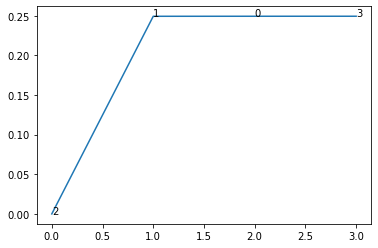

In [10]:
import matplotlib.pyplot as plt
data, labels = to_plot(get_singular_sum(GH_PLUS_Z))
plt.plot(data)
for i, label in enumerate(labels):
    plt.annotate(str(label), (i, data[i]))

# Rolling the Bell-Bell tensor

In [11]:
core, matrices = tl.decomposition.tucker(BELL_BELL, rank=BELL_BELL.shape)

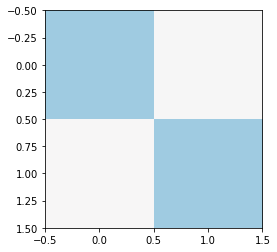

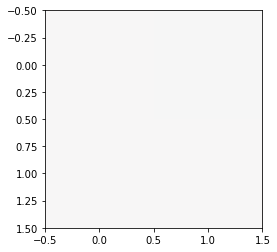

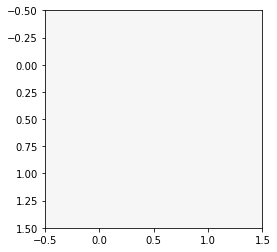

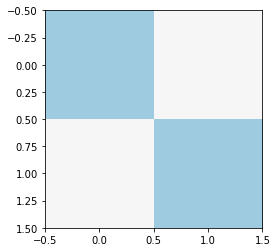

In [12]:
for i in range(4):
    plt.imshow(core.reshape(2, 2, -1)[:, :, i], vmax=1, vmin=-1, cmap="RdBu")
    plt.show()

# Hypothesis test

In [13]:
def get_singular_group_sum(tensor, k=2):
    import itertools
    from collections import Counter
    core, matrices = tl.decomposition.tucker(tensor, rank=tensor.shape)
    result = Counter()
    for index in itertools.product([0, 1], repeat=len(tensor.shape)):
        value = core[index]
        for subindex in itertools.product([0, 1], repeat=k):
            for pair in itertools.combinations(range(len(tensor.shape)), r=k):
                tpl = tuple(subindex + pair)
                if all(index[pair[i]] == subindex[i] for i in range(k)):
                    result[tpl] += abs(value) ** 2
            
    return result.most_common()[::-1]

In [14]:
get_singular_group_sum(GHZ_BELL, k=3)

[((0, 1, 0, 1, 3, 4), 3.4223107581503633e-07),
 ((1, 0, 1, 1, 3, 4), 3.6840976328478004e-07),
 ((0, 1, 0, 0, 3, 4), 3.7504828062031555e-07),
 ((1, 0, 1, 0, 3, 4), 4.073026303406776e-07),
 ((0, 1, 0, 2, 3, 4), 4.777591697821706e-07),
 ((1, 0, 1, 2, 3, 4), 4.98220836517513e-07),
 ((0, 0, 1, 2, 3, 4), 5.818163649001804e-07),
 ((0, 0, 1, 0, 3, 4), 6.727345710770159e-07),
 ((0, 0, 1, 1, 3, 4), 7.116274381329133e-07),
 ((1, 1, 0, 2, 3, 4), 8.497615397601562e-07),
 ((1, 1, 0, 0, 3, 4), 9.524724289220113e-07),
 ((1, 1, 0, 1, 3, 4), 9.852896337272905e-07),
 ((0, 1, 1, 0, 1, 2), 0.0006720959777312039),
 ((1, 0, 1, 0, 1, 2), 0.0009686502465793846),
 ((1, 0, 0, 0, 1, 4), 0.005309839959745591),
 ((1, 0, 0, 0, 1, 3), 0.005309894233388004),
 ((0, 1, 1, 0, 1, 4), 0.005314439798399403),
 ((0, 1, 1, 0, 1, 3), 0.005314457234828852),
 ((0, 1, 0, 0, 1, 3), 0.005359857197918817),
 ((0, 1, 0, 0, 1, 4), 0.005359874634348266),
 ((1, 0, 1, 0, 1, 3), 0.005364860234065939),
 ((1, 0, 1, 0, 1, 4), 0.005364914507708